# Test: Aplicación de cargas puntuales en una placa cuadrada

En este tutorial exploraremos cómo aplicar **cargas puntuales** sobre nodos específicos de una malla. Utilizaremos una geometría simple: una placa cuadrada de lado $0.156\,\text{m}$, empotrada en su borde inferior y sometida a dos fuerzas verticales concentradas en nodos del borde superior. El objetivo es mostrar el uso de los métodos `apply_point_loads` y visualizar los desplazamientos resultantes.

## 1. Descripción del problema

* **Geometría**: placa cuadrada de $0.156 \times 0.156\,\text{m}^2$.
* **Material**: acero ($E = 210\,\text{GPa}$, $\nu = 0.3$), espesor $t = 1.0\,\text{m}$ (para simplificar, se usa espesor unitario).
* **Condiciones de borde**: empotramiento ($u_x = u_y = 0$) en los nodos del borde inferior (lado $y = 0$).
* **Cargas**: dos fuerzas puntuales de $100\,000\,\text{N}$ (100 kN) cada una, aplicadas verticalmente hacia arriba en los nodos superior derecho (índices 56 y 63 de la malla estructurada $8\times8$).

## 2. Implementación paso a paso

### 2.1 Importación de módulos y creación de la malla

Comenzamos importando `numpy` y las clases de `femppp`. Definimos las dimensiones y generamos una malla estructurada de $8\times8$ puntos.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from femppp import *

# Dimensiones de la placa
xl = 0.156
yl = 0.156

# Malla estructurada 8x8
nx = ny = 8
x = np.linspace(0.0, xl, nx)
y = np.linspace(0.0, yl, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

# Triangulación
tess = Tessellation(points)


### 2.2 Visualización de la malla con numeración de nodos y elementos

Para identificar los nodos donde aplicaremos las cargas, es útil visualizar la malla mostrando los identificadores de nodos y elementos.


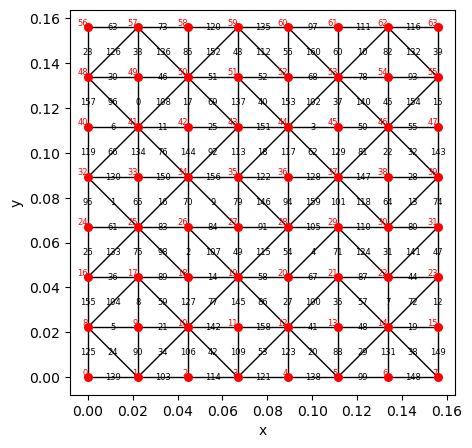

In [2]:
tess.plot(    
    show_node_ids=True,
    show_element_ids=True,
    node_ids_size=6,
    element_ids_size=6,
    figure_size=(5,5)
)

En la figura resultante, observamos que los nodos superiores tienen índices 56, 57, 58, 59, 60, 61, 62, 63. Elegimos los nodos 56 y 63 (extremos del borde superior) para aplicar las fuerzas.

### 2.3 Creación de los elementos finitos (CST)

Creamos un objeto `TriangularElement` para cada triángulo de la malla.


In [3]:
elements = []
for tri in tess.simplices:
    elem = TriangularElement(
        node_ids=tri,
        nodes=tess.points,
        E=210e9,
        nu=0.3,
        thickness=1.0,
        element_type="CST"
    )
    elements.append(elem)

### 2.4 Ensamblaje del problema

Construimos el objeto `FEMProblem` y ensamblamos la matriz de rigidez global.


In [4]:
problem = FEMProblem(elements)
problem.assemble_stiffness()


La matriz $K$ se puede observar de la siguiente manera:

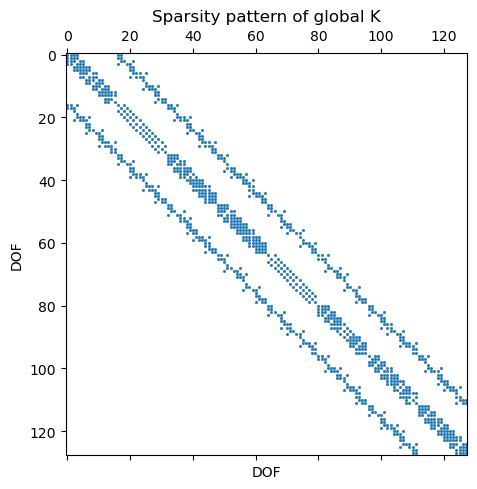

In [13]:
problem.plot_stiffness_sparsity(figsize=(5,5))

### 2.5 Aplicación de cargas puntuales

Usamos el método `apply_point_loads`. Debemos proporcionar una lista de nodos y una matriz de valores (cada fila corresponde a un nodo, con las componentes $F_x, F_y$).


In [6]:
point_load_nodes = [56, 63]
point_load_values = np.array([
    [0.0, 100000.0],   # nodo 56: fuerza vertical hacia arriba
    [0.0, 100000.0]    # nodo 63: fuerza vertical hacia arriba
])

problem.apply_point_loads(
    nodes=point_load_nodes,
    values=point_load_values
)


### 2.6 Condiciones de borde: empotramiento inferior

Fijamos todos los grados de libertad de los nodos del borde inferior ($y = 0$). En nuestra malla estructurada, los primeros 8 nodos (índices 0 a 7) corresponden a la fila inferior.


In [7]:
dirichlet_nodes = list(range(8))   # nodos 0..7
dirichlet_values = np.zeros((8, 2))
problem.apply_dirichlet_bcs(nodes=dirichlet_nodes, values=dirichlet_values)


### 2.7 Solución del sistema

Resolvemos el sistema lineal mediante el método del gradiente conjugado.


In [8]:
problem.solve(method="cg", tol=1e-10)

### 2.8 Visualización de resultados

Mostramos el campo de magnitud de desplazamiento ($\overline{U} = \sqrt{u_x^2 + u_y^2}$) mediante un gráfico de contorno sobre la malla.


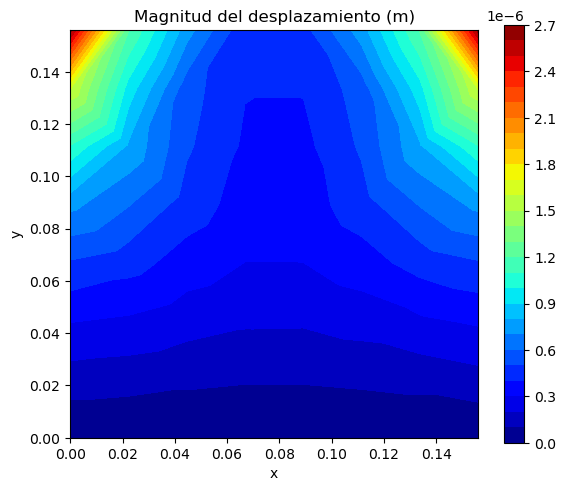

In [9]:
plot_fem_contour(
    points=tess.points,
    simplices=tess.simplices,
    nodal_values=problem.umag,
    title="Magnitud del desplazamiento (m)",
    cmap="jet",
    show_scale=True
)


También podemos visualizar la deformada amplificada para apreciar la forma que adquiere la placa bajo las cargas.

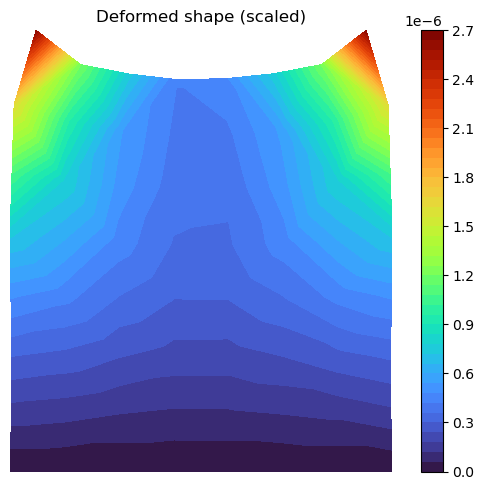

In [10]:
plot_deformed_contour(
    tess.points,
    tess.simplices,
    problem.ux,
    problem.uy,
    scale=10000   # amplificación visual
)